In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

gl.canvas.set_target('ipynb')

# put in the path to the kaggle data
PATH_TO_JSON = "docs_prod_03/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

[WARNING] This Python session does not appear to be running in an interactive IPython Notebook. Use of the 'ipynb' target may behave unexpectedly or result in errors.


In [3]:
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False)
sf = sf.unpack('X1',column_name_prefix='')

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-11891 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1442443952.log
[INFO] GraphLab Server Version: 1.5.2


PROGRESS: Finished parsing file /mnt/data/docs_prod_03/20
PROGRESS: Parsing completed. Parsed 100 lines in 0.144866 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/20
PROGRESS: Read 5681 lines. Lines per second: 14785.2
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/7
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/24
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/2
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/0
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/54
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/51
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/42
PROGRESS: Finished parsing file /mnt/data/

In [5]:
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS)

PROGRESS: Finished parsing file /mnt/data/input/train.csv
PROGRESS: Parsing completed. Parsed 100 lines in 0.156808 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/input/train.csv
PROGRESS: Parsing completed. Parsed 337024 lines in 0.1385 secs.
PROGRESS: Finished parsing file /mnt/data/input/sampleSubmission.csv
PROGRESS: Parsing completed. Parsed 100 lines in 0.054045 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
---------------------------

In [6]:
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

In [7]:
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))

In [9]:
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

In [12]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

In [14]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf'))
train = encoder.transform(train)
test = encoder.transform(test)

In [32]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=14, 
                                                                  output_column_name='tfidf_hashed_14'))
train['tfidf_hashed_14'] = hash_encoder.transform(train)['tfidf_hashed_14']
test['tfidf_hashed_14'] = hash_encoder.transform(test)['tfidf_hashed_14']

In [32]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=13, 
                                                                  output_column_name='tfidf_hashed_13'))
train['tfidf_hashed_13'] = hash_encoder.transform(train)['tfidf_hashed_13']
test['tfidf_hashed_13'] = hash_encoder.transform(test)['tfidf_hashed_13']

In [35]:
train_train_2, train_cv_2 = train.random_split(0.86, seed=103)

In [25]:
train_train.save('dataset_3_train_train')
train_cv.save('dataset_3_train_cv')
test.save('dataset_3_test')
#gl.logistic_classifier.create?

In [57]:
model = gl.logistic_classifier.create(train_train_2, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=train_cv_2,
                                      class_weights='auto',
                                      max_iterations=60,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 289704
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 16384
PROGRESS: Number of coefficients    : 16385
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000003  | 3.573601     | 0.543513          | 0.534214            |
PROGRESS: | 2         | 5        | 1.000000  | 7.060986     | 0.845798          | 0.836010            |
PROGRESS: | 3         | 6        | 1.000000  | 9.366140     | 0.7442

In [39]:
results = model.evaluate(train_cv_2, metric='roc_curve')

In [48]:
a = results['roc_curve']

In [56]:
a

threshold,fpr,tpr,p,n
0.0,0.174656331233,0.0269155632733,4607,42701
0.0010000000475,0.825343668767,0.973084436727,4607,42701
0.00200000009499,0.800332544905,0.969394399826,4607,42701
0.00300000002608,0.784150254092,0.968309094856,4607,42701
0.00400000018999,0.771340249643,0.966355545908,4607,42701
0.00499999988824,0.760450574928,0.964836118949,4607,42701
0.00600000005215,0.75127046205,0.963533752985,4607,42701
0.00700000021607,0.74234795438,0.962665509008,4607,42701
0.00800000037998,0.733940657127,0.961363143043,4607,42701
0.00899999961257,0.726423268776,0.960494899067,4607,42701


AUC = 0.864690


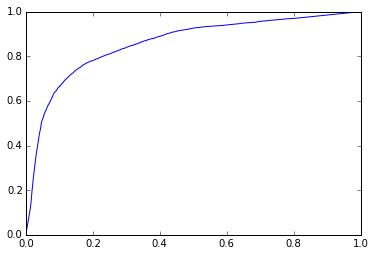

In [75]:
fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

AUC = 0.864690


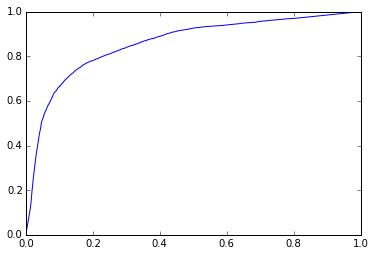

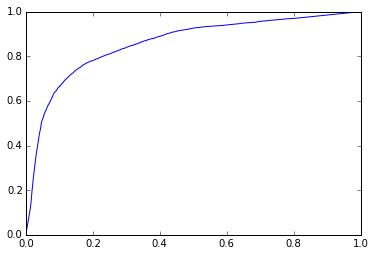

## model

In [ ]:
ypred = model.predict(test)

In [ ]:
submission = gl.SFrame()
submission['sponsored'] = ypred 
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission.save('submission_version_4.csv', format='csv')

In [33]:
test.head()

sponsored,id,text,bow,tfidf
0,3232985,follow shoe tale foodfamili serious serious ...,"{'trifl': 4, 'forget': 1,'laci': 11, 'global': 2, ...","{'trifl':25.981845627461617, ..."
0,3232805,watch hous hear irannuclear deal watch au ...,"{'shop': 1, 'peacock': 1,'code': 1, 'feedback' ...","{'shop':1.7292320990130188, ..."
0,3232793,beij municip commisstourism develop ...,"{'shop': 1, 'summer': 1,'code': 1, 'show': 1, ...","{'shop':1.7292320990130188, ..."
0,3232745,creat post participdiscuss free sign ...,"{'photoshop': 1,'feedback': 1, 'john' ...","{'photoshop':4.2047341603221415, ..."
0,3232715,webmast resourc hoststatu updat click here ...,"{'coach': 9, 'queri': 5,'code': 9, ...","{'coach':33.32100230896354, ..."
0,3232625,revpart prototyp madeeasi kathryn leav com ...,"{'explor': 1, 'comment':4, 'liquid': 1, 'code': ...","{'explor':2.510998954935867, ..."
0,3232577,sign thi item yourwishlist follow mark ...,"{'vietgam': 1, 'albion':1, 'violenc': 1, ...","{'refund':9.408058861362097, ..."
0,3232529,issu year save coverprice soccer player have ...,"{'peacock': 1,'cincinnati': 2, ...","{'peacock':5.937812187902022, ..."
0,323249,philadelph convent centerphiladelph aacr annual ...,"{'follow': 1,'marinesci': 2, ...","{'sector':4.078460652879218, ..."
0,3232475,just look cute theyviciou without regret ...,"{'ouch': 1, 'yellow': 3,'soften': 3, 'laura': 1, ...","{'ouch':6.1389829458824074, ..."
